# Women on Board

### Exploring the Influence of Gender Diversity: Does C25 Stock Performance Correlate with Female Representation on Boards of Directors?

#### I examine the potential connection between the presence of women on boards of directors and the performance metrics of stocks in the C25 index, investigating whether gender diversity plays a role in financial outcomes such as returns and risks.

To conduct the analysis, I utilize data from finans.dk on the percentage of women on boards in C25 stocks, retrieved on 30 of March, 2023. Additionally, I download data for the stocks and the C25 index using Yahoo Finance.

I explore the datasets by plotting the returns of each stock compared to the C25, visualizing the proportion of women on boards for each company, and comparing the expected return and risk (meausered by standard deviation) of each stock on the C25 index to the amount of women on boards. Notably, the plots does not seem to yield any correlation between expected returns, risk and the number of women on boards.

Finally, I create a new portfolio weighted by the number of women on boards, assuming that the composition has remained consistent for the past three years. Comparing the new portfolio to the C25 index, I find that weighting the index by women on boards does not underperform compared to the market.

While this is not conclusive evidence that women on boards improve performance, as numerous portfolios could be created from the C25 index, it does not suggest that having women on boards is a detrimental strategy.

To run this notebook you have to install yfinance and adjustText.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns
import warnings
from datetime import datetime

# Ignore all warnings
warnings.filterwarnings('ignore')

# Autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# Install adjustText
#%pip install adjustText
from adjustText import adjust_text

# Install yfinance
#%pip install yfinance
import yfinance as yf

# User written modules
import dataproject as dp

# Predefined options for all plots
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
plt.rcParams.update({'font.size': 12})

# Reading and Cleaning Data

I import a CSV file that includes the companies in the C25 index, a yfinance ticker, and the percentage of female board members for each company.

In [2]:
# Read file, sort values descending and reset index
C25F = (pd.read_csv('C25F.csv')
        .sort_values(by =['femaleboard'], ascending=False)
        .reset_index(drop=True))

# Display DataFrame
#C25F.head()

I generate a list of yfinance tickers to pass as input to yfinance.

In [3]:
# Generate a list of yfinance tickers
C25_tickers = list(C25F['yfinanceticker'])

I download historical prices adjusted for dividends, stock splits and offerings from yfinance.

In [4]:
# Download historical market data
hist_p = yf.download(tickers = C25_tickers, start = '2020-03-01',
                        end = '2023-04-01',
                        interval = '1mo')

# Get adjusted close for each stock and change dates
hist_p = hist_p['Adj Close']

# Change dateformat
hist_p.index = pd.to_datetime(hist_p.index, format='%m-%y')

# Display DataFrame
#hist_p.head()

[*********************100%%**********************]  26 of 26 completed

1 Failed download:
['CHR.CO']: Exception('%ticker%: No timezone found, symbol may be delisted')


In [5]:
# Calculate monthly and cumulative returns 
hist_mr, hist_cr = dp.calculate_returns(hist_p)

# Set the first row of the cumulative returns to 1
hist_cr.iloc[0] = 1

# Display DataFrame
#hist_cr.head()

## Exploring the Data

To explore the data, I first visualize the cumulative returns of each stock relative to the C25 index.
<br>
Next, I present a bar chart which show the proportion of female board members on each company.

In [6]:
print(hist_cr.index.name)

Date


In [7]:
# Define type of widget, the options to choose from and the description next to the Dropdown
stockpicker = widgets.Dropdown(options=C25_tickers, description='Stock:')

# Display the interactive plot using widgets interact
widgets.interact(dp.cum_ret_plot, data = widgets.fixed(hist_cr), stock = stockpicker,
                # Set reference
                ref = widgets.fixed('^OMXC25'),
                # Set figure no.
                fig = widgets.fixed(1),
                # ax_data are only for non-interactive plots
                ax_data=widgets.fixed(None));

interactive(children=(Dropdown(description='Stock:', options=('GN.CO', 'PNDORA.CO', 'CHR.CO', 'COLO-B.CO', 'GM…

Figure 1 illustrates the cumulative return from investing 1 kr in a stock within the C25 index instead of investing in the index itself.

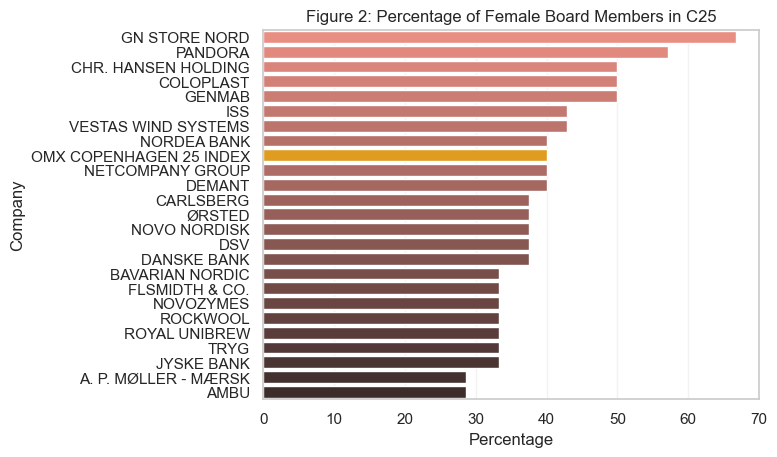

In [8]:
# Set theme
sns.set(style="whitegrid")

# Create a list with n colors of the palette dark:salmon_r
palette = list(sns.color_palette('dark:salmon_r', n_colors = len(C25F)))

# Insert the color 'orange' in the list of colors using the index of C25
palette.insert(C25F[C25F['company'] == 'OMX COPENHAGEN 25 INDEX'].index[0], 'orange')

# Create the bar chart with the custom palette
ax = sns.barplot(x='femaleboard', y='company', data=C25F, palette=palette) 

# Set the title and labels
ax.set_title('Figure 2: Percentage of Female Board Members in C25', fontsize = 12)
ax.set_xlabel('Percentage', fontsize = 12)
ax.set_ylabel('Company', fontsize = 12)

# Show the plot
plt.show();

Figure 2 illustrates the percentage of female board members for each company in the C25 index. On average, 40 percent of board members are female, with some companies, such as GN Store Nord, having a significantly higher proportion, while others, like Maersk, have a much lower representation. Further analysis could be conducted to determine whether this disparity is industry-dependent.

# Merging and Analyzing the Data

I calculate expected monthly returns and standard deviations for each stock.

In [9]:
# Calculate expected monthly returns, standard deviation, convert to DataFrame, reset index, and rename columns
hist_emr = (hist_mr * 100).agg(['mean', 'std']) \
                             .transpose() \
                             .reset_index() \
                             .rename(columns={
                                 'Ticker': 'yfinanceticker',
                                 'mean': 'expectedmonthly',
                                 'std': 'stdmonthly'
                             })

I merge the datasets `hist_emr` and `C25F`.

In [10]:
fmr = pd.merge(hist_emr,
                C25F,
                on=['yfinanceticker'])

## Correlation of Expected Monthly Returns, Standard Deviation and Women on Board of Directors 

I create plots to estimate if there is a relationship between the expected monthly return, standard deviation and the percentage of women on the board of directors. 

posx and posy should be finite values


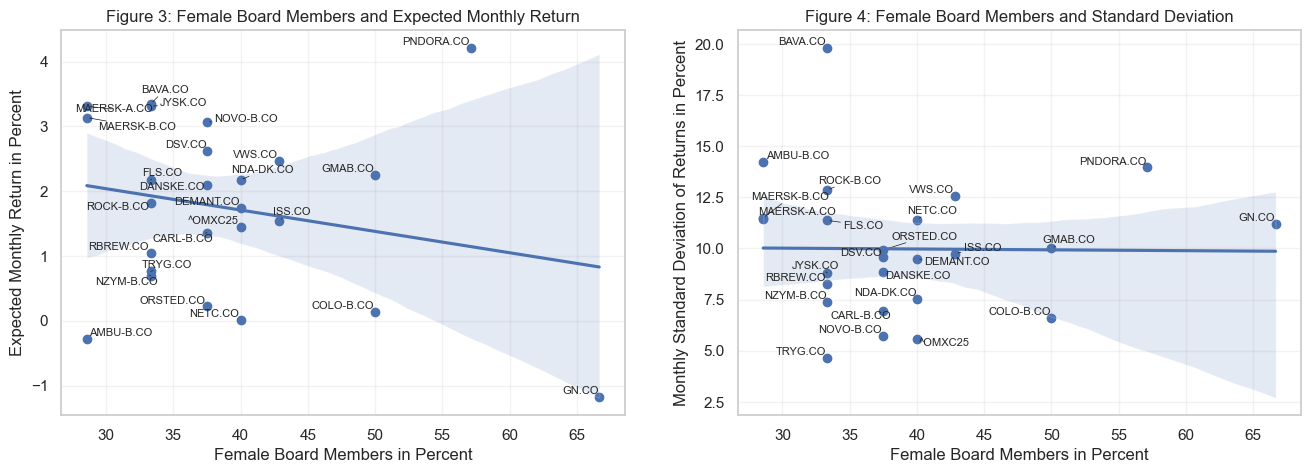

In [11]:
# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Monthly return
x = fmr['femaleboard']
y1 = fmr['expectedmonthly']
labels = fmr['yfinanceticker']
title1 = 'Figure 3: Female Board Members and Expected Monthly Return'
xlabel = 'Female Board Members in Percent'
ylabel1 = 'Expected Monthly Return in Percent'

# Call function to create a scatterplot with labels
dp.plot_scatter_with_labels(ax = ax1, 
                            x = x, 
                            y = y1, 
                            labels = labels, 
                            title = title1, 
                            xlabel = xlabel, 
                            ylabel = ylabel1)

# Standard deviation
y2 = fmr['stdmonthly']
title2 = 'Figure 4: Female Board Members and Standard Deviation'
ylabel2 = 'Monthly Standard Deviation of Returns in Percent'

# Call function to create a scatterplot with labels
dp.plot_scatter_with_labels(ax = ax2, 
                            x = x, 
                            y = y2, 
                            labels = labels, 
                            title = title2, 
                            xlabel = xlabel, 
                            ylabel = ylabel2)

# Show the plots
plt.show();

There does not appear to be a significant correlation in either plot. <br>
Figure 3 indicates that having more women on the board of directors does not seem to influence the average monthly returns, as the confidence bands are wide, and the trend line is likely influenced by the outlier GN Store Nord. Figure 4 also shows no clear relationship between the number of women on the board and the monthly standard deviation. In other words, having more or fewer women on the board of directors does not affect the expected monthly return or the risk of holding a stock.

I remove GN Store Nord to evaluate if it has a significant downward impact on the trend line for the expected return and recreate the plots.  

In [12]:
# Remove GN Store Nord and reset index to make a copy
wo_gn_fmr = fmr.loc[fmr['yfinanceticker'] != 'GN.CO'].reset_index(drop=True)


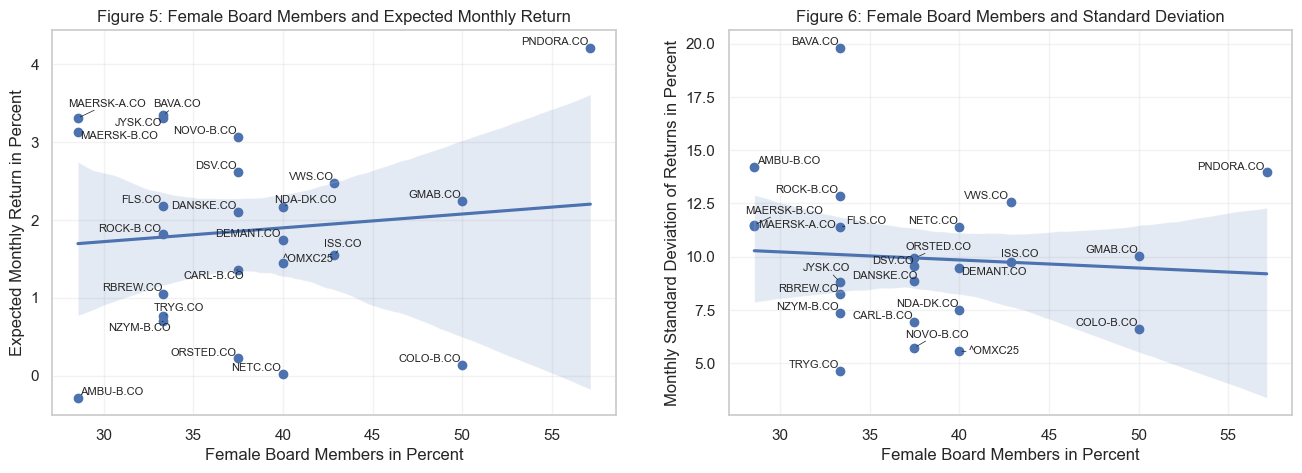

In [13]:
# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Monthly return
x = wo_gn_fmr['femaleboard']
y1 = wo_gn_fmr['expectedmonthly']
labels = wo_gn_fmr['yfinanceticker']
title1 = 'Figure 5: Female Board Members and Expected Monthly Return'
xlabel = 'Female Board Members in Percent'
ylabel1 = 'Expected Monthly Return in Percent'

# Call function to create scatterplot with labels
dp.plot_scatter_with_labels(ax = ax1, 
                            x = x, 
                            y = y1, 
                            labels = labels, 
                            title = title1, 
                            xlabel = xlabel, 
                            ylabel = ylabel1)

# Standard deviation
y2 = wo_gn_fmr['stdmonthly']
title2 = 'Figure 6: Female Board Members and Standard Deviation'
ylabel2 = 'Monthly Standard Deviation of Returns in Percent'

# Call function to create scatterplot with labels
dp.plot_scatter_with_labels(ax = ax2, 
                            x = x, 
                            y = y2, 
                            labels = labels, 
                            title = title2, 
                            xlabel = xlabel, 
                            ylabel = ylabel2)

# Show the plots
plt.show()

From Figure 5, having removed GN Store Nord, it is clear that the number of women on the board of directors does not significantly impact the expected monthly return as the confidence bands are still very wide, and the trend line slope is now close to zero. 
In Figure 6, having removed GN Store Nord, the confidence bands are still wide (less so than in Figure 5), but the slight downward slope is more pronounced, which may indicate that having more women on the board of directors could decrease the risk of holding a stock. 

## Portfolio weighted by Proportion of Women on Board of Direectors

I create a portfolio weighted by the proportion of women on the board of directors for each company.

In [14]:
# Remove OMX COPENHAGEN 25 and reset index to make a copy
wC25F = C25F.loc[C25F['company'] != 'OMX COPENHAGEN 25 INDEX'].reset_index(drop=True)

# Update Maersk A and B by dividing by 2
wC25F.loc[wC25F['yfinanceticker'].isin(['MAERSK-A.CO', 'MAERSK-B.CO']), 'femaleboard'] /= 2

# Normalize femaleboard to 1
wC25F['femaleboard'] = dp.normalize_column(wC25F['femaleboard'])

# Remove # to see portfolio weights
#wC25F.head()

In [15]:
# Sort values ascending to match w_hist_mr
wC25F = wC25F.sort_values('yfinanceticker', ascending=True)

# Create list for weights
wC25F_list = wC25F['femaleboard'].values.tolist()

# Remove column with C25 index
w_hist_mr = hist_mr.drop(columns = '^OMXC25')

# Sort columns ascending to match wC25F
sorted_columns = sorted(w_hist_mr.columns)
w_hist_mr = w_hist_mr[sorted_columns]

In [16]:
# Calculate portfolio returns
port_r, cum_port_r = dp.calculate_portfolio_returns(data = w_hist_mr, weights = wC25F_list)

# Convert to dataframe
cum_port_r = cum_port_r.to_frame(name='^WOMXC25')


I create a plot of the cumulative returns of each stock relative to the WC25 index.

In [17]:
# Create a new list of tickers which includes ^WOMXC25
C26_tickers = C25_tickers + list(cum_port_r.columns)

# Merge cum_port_ret to hist_cr
hist_cr = pd.merge(hist_cr, cum_port_r, left_index=True, right_index=True, how='outer')

# Define type of widget, the options to choose from and the description next to the Dropdown
stockpicker = widgets.Dropdown(options=C26_tickers, description='Stock:')

# Display the interactive plot using widgets interact
widgets.interact(dp.cum_ret_plot, data=widgets.fixed(hist_cr), stock=stockpicker,
                # set reference
                ref = widgets.fixed('^WOMXC25'),
                # set figure no.
                fig = widgets.fixed(7),
                # ax_data are only for non-interactive plots
                ax_data=widgets.fixed(None));

interactive(children=(Dropdown(description='Stock:', options=('GN.CO', 'PNDORA.CO', 'CHR.CO', 'COLO-B.CO', 'GM…

When examining the portfolio weighted on the proportion of female board members, it becomes evident that the return is marginally greater than that of the C25 index. One possible explanation for this difference could be the continuous weighting of the C25 index by each company's market value, capped at 15%. In the C25 index, the underperformance of larger companies has a significant impact, whereas, in the gender-weighted portfolio, this effect is mitigated.

# Conclusion

The analysis does not provide definitive evidence regarding the impact of female board members on investor returns and risks. While a portfolio weighted by the presence of women on boards demonstrates a slightly higher performance than the C25 index, this could be attributed to the composition methodology of the C25 index itself. It is plausible that other portfolios with more evenly distributed stock weights could also outperform the C25. As a result, I find no concrete proof that an increased number of women on the board of directors directly correlates to lower or higher investment returns or standard deviation compared to the C25 index.